# GenHack 4 - ChefAI - Predictive Modeling

- **Group**: ChefAI  
- **Period**: 4 - Predictive Modeling & Machine Learning

## Project Overview

This notebook develops **machine learning classifiers to predict Urban Heat Island (UHI) risk levels** based on environmental and geographic features. Unlike previous weeks that focused on data exploration and statistical analysis, this week implements **operational ML models** that can classify locations into risk categories for urban planning decisions.

### Core Objective
Build classification models that predict whether a location has **Low, Medium, or High UHI discrepancy risk** using:
- **Meteorological features** (temperature, wind, precipitation from ERA5)
- **Geographic features** (elevation, coordinates)
- **Vegetation index** (NDVI - proxy for urbanization)
- **Urbanization level** (DEGURBA - official EU urban density classification)

### Why Classification Instead of Regression?
While predicting exact UHI discrepancy values (regression) is scientifically interesting, **risk categories are more actionable** for decision-makers:
- **Low risk**: Standard urban planning procedures
- **Medium risk**: Enhanced monitoring and vegetation strategies
- **High risk**: Priority intervention zones requiring cooling infrastructure

### Machine Learning Approach
1. **Balanced classes**: Quantile-based binning ensures each risk category has ~33% of data
2. **Multiple algorithms**: Compare 7 different ML techniques to find optimal approach
3. **Proper validation**: Train/test split with stratification to ensure robust evaluation
4. **Feature importance**: Understand which factors drive UHI risk predictions

### Expected Outcome
A trained classifier that can predict UHI risk for any location in Italy given its environmental characteristics, enabling proactive urban heat mitigation planning.

In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

## 1. Load DEGURBA Urbanization Data

### What is DEGURBA?

The **Degree of Urbanization (DEGURBA)** is the European Commission's official classification system that categorizes areas by population density and urban characteristics. It's based on **1km² grid cells** aggregated to administrative units (comuni in Italy).

### Classification System

- **Class 1 - Cities**: Densely populated areas (urban centers >50,000 inhabitants)
- **Class 2 - Towns and suburbs**: Intermediate density areas
- **Class 3 - Rural areas**: Thinly populated areas

### Data Format

CSV file with **semicolon delimiter** (European standard) containing:

- `Comune`: Municipality name (to match with GADM administrative boundaries)
- `Degurba 2021`: Classification value (1, 2, or 3)


In [76]:
# Load DEGURBA data
degurba_df = pd.read_csv("../data/degurba.csv", sep=";")
degurba_df.sample(5)

,Codice Ripartizione geografica,Codice Regione,Codice Provincia/Uts,Codice Provincia (Storico),Codice Comune (alfanumerico),Codice comune (numerico),Comune,Comune (dizione straniera),Sigla automobilistica,Comune isolano,...,Degurba 2011,Degurba 2021,Codice Ecoregioni-Divisioni,Ecoregioni - Divisioni,Codice Ecoregioni-Province,Ecoregioni - Province,Codice Ecoregioni-Sezioni,Ecoregioni - Sezioni,Codice Ecoregioni-Sottosezioni,Ecoregioni - Sottosezioni
5111,4,15,263,63,63056,63056,Pollena Trocchia,NaN,NaN,0,...,1,1,2,Divisione Mediterranea,2B,Provincia Tirrenica,2B2,Sezione Tirrenica meridionale,2B2a,Sottosezione Campana Tirrenica Occidentale
5682,4,13,69,69,69058,69058,Ortona,NaN,CH,0,...,2,2,2,Divisione Mediterranea,2C,Provincia Adriatica,2C1,Sezione Adriatica Centrale,2C1a,Sottosezione Costiera di Marche e Abruzzo
139,1,1,201,1,1142,1142,Macello,NaN,TO,0,...,3,3,1,Divisione Temperata,1B,Provincia Padana,1B1,Sezione Padana,1B1c,Sottosezione Bacino Occidentale del Po
1366,1,3,12,12,12030,12030,Cantello,NaN,VA,0,...,2,2,1,Divisione Temperata,1A,Provincia Alpina,1A2,Sezione Alpina Centro-Orientale,1A2a,Sottosezione Prealpina
1021,1,1,6,6,6183,6183,Villalvernia,NaN,AL,0,...,3,3,1,Divisione Temperata,1B,Provincia Padana,1B1,Sezione Padana,1B1c,Sottosezione Bacino Occidentale del Po


## 2. Load GADM Administrative Boundaries

### Why We Need GADM

Our UHI data has **point coordinates** (x, y), while DEGURBA data is **comunale-level** (administrative area). GADM provides the **geographic polygons** that allow us to:

1. Match comuni names from DEGURBA with actual geographic boundaries
2. Perform **spatial joins**: determine which comune each UHI data point falls within
3. Assign DEGURBA urbanization values to point measurements

### Spatial Join Strategy

```
Point data (x, y) + GADM polygons (NAME_3) + DEGURBA (comune name) → Point with DEGURBA value
```

**Important**: GADM uses **EPSG:4326** (WGS84 lat/lon), but our data uses **EPSG:3035** (LAEA Europe projection). We'll need coordinate system transformations.


In [ ]:
# Load GADM data and filter for Italy
gadm = gpd.read_file("../data/gadm_410_europe.gpkg")
gadm_comuni = gadm[gadm["NAME_0"] == "Italy"].copy()

print(f"GADM Italy comuni: {len(gadm_comuni):,} polygons")
print(f"GADM CRS: {gadm_comuni.crs}")
print(f"\nRelevant columns: {['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'geometry']}")

GADM Italy comuni: 8,100 polygons
GADM CRS: EPSG:4326

Relevant columns: ['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'geometry']


## 3. Merge GADM with DEGURBA


In [ ]:
# Clean comune names for better matching
gadm_comuni["NAME_3_clean"] = gadm_comuni["NAME_3"].str.strip()
degurba_df["Comune_clean"] = degurba_df["Comune"].str.strip()

# Merge GADM with DEGURBA on comune name
gadm_degurba = gadm_comuni.merge(
    degurba_df[["Comune_clean", "Degurba 2021"]], left_on="NAME_3_clean", right_on="Comune_clean", how="left"
)

# Check match rate
matched = gadm_degurba["Degurba 2021"].notna().sum()
match_rate = matched / len(gadm_comuni) * 100

print(f"✓ Matched comuni: {matched:,} / {len(gadm_comuni):,} ({match_rate:.1f}%)")
print(f"  Unmatched: {len(gadm_comuni) - matched:,}")
print(f"\nDEGURBA distribution in matched comuni:")
print(gadm_degurba["Degurba 2021"].value_counts().sort_index())

✓ Matched comuni: 6,562 / 8,100 (81.0%)
  Unmatched: 1,538

DEGURBA distribution in matched comuni:
Degurba 2021
1.0     252
2.0    2066
3.0    4244
Name: count, dtype: int64


## 4. Load UHI Discrepancy Data

### Data Source
This **Parquet file** contains the processed results from Week 3's analysis:
- **1.75 million rows**: Daily measurements from 70+ weather stations across multiple years
- **Multiple time periods**: 2020-2023 quarterly intervals
- **Multiple regions**: All provinces in Emilia-Romagna

### Key Variables
**Target variable:**
- `UHI_discrepancy`: Difference between ECA (ground truth) and ERA5 (satellite) UHI measurements
  - **High values**: ERA5 significantly underestimates urban heat (poor satellite performance in cities)
  - **Low values**: Good agreement between ground and satellite measurements

**Feature variables:**
- **Meteorological**: `ERA5_t2m` (temperature), `ERA5_u10`/`ERA5_v10` (wind), `ERA5_tp` (precipitation)
- **Geographic**: `x`, `y` (coordinates in EPSG:3035), `HGHT` (elevation)
- **Vegetation**: `NDVI` (Normalized Difference Vegetation Index, proxy for urbanization)
- **UHI metrics**: `ERA5_UHI` (satellite-derived urban heat island intensity)

### Coordinate System
**EPSG:3035 (LAEA Europe)** - A equal-area projection optimized for Europe:
- X values: ~4.2-4.5 million meters
- Y values: ~2.3-2.4 million meters
- **Why not lat/lon?** Equal-area projections are better for spatial analysis and distance calculations

In [79]:
# Load UHI data
uhi_df = pd.read_parquet("../processed/uhi_discrepancy_eca_era5_stats_all_regions.parquet")
uhi_df.sample(5)

,date,y,x,SOUID,ECA_TX,HGHT,ERA5_t2m,ERA5_u10,ERA5_v10,ERA5_tp,NDVI,spatial_ref,ECA_UHI,ERA5_UHI,UHI_discrepancy,region_name,day
960903,2022-05-01,2.426661e+06,4.341405e+06,95409.0,23.7,32.0,19.964996,-0.305681,-0.293225,1.545870e-03,0.223529,0,6.175397,3.457603,2.717793,Parma,2022-05-01T00:00:00
1203065,2022-10-31,2.398341e+06,4.388765e+06,95865.0,25.0,40.0,22.856964,0.772064,0.420156,1.788139e-07,0.003922,0,1.840698,1.210835,0.629863,Modena,2022-10-31T00:00:00
599943,2021-07-01,2.352261e+06,4.498125e+06,97217.0,33.0,10.0,30.904327,1.153758,0.087518,3.020819e-05,0.411765,0,2.073585,1.493780,0.579805,Ravenna,2021-07-01T00:00:00
1212861,2022-09-18,2.373621e+06,4.324845e+06,95833.0,20.6,618.0,17.169525,1.212193,1.166470,1.323096e-03,0.537255,0,-0.380576,-2.482098,2.101522,Parma,2022-09-18T00:00:00
268868,2020-10-10,2.353701e+06,4.474845e+06,95449.0,22.4,32.0,21.334351,0.819426,1.122361,2.099413e-04,0.686275,0,1.347143,0.910686,0.436456,Ravenna,2020-10-10T00:00:00


## 5. Spatial Join: Add DEGURBA to UHI Data

**Handling unmatched**: Fill with mode (most common DEGURBA value) as conservative estimate.


In [80]:
# Create GeoDataFrame from UHI data with point geometries
print("Creating point geometries from x,y coordinates...")
uhi_geo = gpd.GeoDataFrame(
    uhi_df,
    geometry=gpd.points_from_xy(uhi_df.x, uhi_df.y),
    crs="EPSG:3035",  # LAEA Europe projection
)

print(f"✓ UHI GeoDataFrame: {len(uhi_geo):,} points")
print(f"  CRS: {uhi_geo.crs}")

# Convert GADM to same CRS for spatial join
print(f"\nConverting GADM from {gadm_degurba.crs} to EPSG:3035...")
gadm_degurba_3035 = gadm_degurba.to_crs("EPSG:3035")
print("✓ GADM converted to EPSG:3035")

Creating point geometries from x,y coordinates...
✓ UHI GeoDataFrame: 1,750,465 points
  CRS: EPSG:3035

Converting GADM from EPSG:4326 to EPSG:3035...
✓ UHI GeoDataFrame: 1,750,465 points
  CRS: EPSG:3035

Converting GADM from EPSG:4326 to EPSG:3035...
✓ GADM converted to EPSG:3035
✓ GADM converted to EPSG:3035


In [81]:
# Perform spatial join (this may take a few minutes)
print("\nPerforming spatial join (points within polygons)...")
print("This may take several minutes for large datasets...")

uhi_with_degurba = gpd.sjoin(
    uhi_geo,
    gadm_degurba_3035[["geometry", "NAME_1", "NAME_2", "NAME_3", "Degurba 2021"]],
    how="left",
    predicate="within",
)

# Check results
matched_points = uhi_with_degurba["Degurba 2021"].notna().sum()
missing_points = uhi_with_degurba["Degurba 2021"].isna().sum()
match_rate = matched_points / len(uhi_with_degurba) * 100

print("\n✓ Spatial join complete!")
print(f"  Matched points: {matched_points:,} ({match_rate:.1f}%)")
print(f"  Unmatched points: {missing_points:,} ({100 - match_rate:.1f}%)")

# Fill missing DEGURBA values with most common value
if missing_points > 0:
    most_common = uhi_with_degurba["Degurba 2021"].mode()[0]
    print(f"\nFilling {missing_points:,} missing values with mode: {most_common}")
    uhi_with_degurba.loc[uhi_with_degurba["Degurba 2021"].isna(), "Degurba 2021"] = most_common

# Convert to integer
uhi_with_degurba["DEGURBA"] = uhi_with_degurba["Degurba 2021"].astype(int)

print(f"\n✓ Final dataset: {len(uhi_with_degurba):,} rows with DEGURBA")
print("\nDEGURBA distribution:")
degurba_counts = uhi_with_degurba["DEGURBA"].value_counts().sort_index()
for val, count in degurba_counts.items():
    pct = count / len(uhi_with_degurba) * 100
    urban_type = {1: "Cities", 2: "Towns/Suburbs", 3: "Rural"}[val]
    print(f"  {val} ({urban_type:15s}): {count:9,} ({pct:5.1f}%)")


Performing spatial join (points within polygons)...
This may take several minutes for large datasets...

✓ Spatial join complete!
  Matched points: 1,462,077 (83.5%)
  Unmatched points: 288,388 (16.5%)

Filling 288,388 missing values with mode: 3.0

✓ Final dataset: 1,750,465 rows with DEGURBA

DEGURBA distribution:
  1 (Cities         ):   253,660 ( 14.5%)
  2 (Towns/Suburbs  ):   434,396 ( 24.8%)
  3 (Rural          ): 1,062,409 ( 60.7%)

✓ Spatial join complete!
  Matched points: 1,462,077 (83.5%)
  Unmatched points: 288,388 (16.5%)

Filling 288,388 missing values with mode: 3.0

✓ Final dataset: 1,750,465 rows with DEGURBA

DEGURBA distribution:
  1 (Cities         ):   253,660 ( 14.5%)
  2 (Towns/Suburbs  ):   434,396 ( 24.8%)
  3 (Rural          ): 1,062,409 ( 60.7%)


## 6. Create Risk Classes (Binning)

### Quantile-Based Binning Strategy

We divide the data into **3 balanced classes** using quantiles (33rd and 67th percentiles):

```
Low Risk    (0-33%):  UHI discrepancy ≤ Q1  → Good ERA5 accuracy
Medium Risk (33-66%): Q1 < discrepancy ≤ Q2 → Moderate concern
High Risk   (66-100%): discrepancy > Q2     → Priority intervention zones
```

**Why quantiles?** Ensures each class has equal representation (~33% each), preventing class imbalance issues in ML models.

### Interpretation

- **Low risk**: ERA5 performs well here
- **Medium risk**: Noticeable discrepancies requiring monitoring
- **High risk**: Large discrepancies indicating dense urban areas where ERA5 fails to capture micro-climate effects


In [82]:
# Define risk classes using quantile-based binning
n_classes = 3
class_labels = ["Low", "Medium", "High"]

# Calculate quantile-based bin edges
quantiles = uhi_with_degurba["UHI_discrepancy"].quantile([0, 1 / 3, 2 / 3, 1]).values
print("Quantile-based bin edges:")
print(f"  Low:    [{quantiles[0]:.3f}, {quantiles[1]:.3f})")
print(f"  Medium: [{quantiles[1]:.3f}, {quantiles[2]:.3f})")
print(f"  High:   [{quantiles[2]:.3f}, {quantiles[3]:.3f}]")

# Create risk class column
uhi_with_degurba["UHI_risk"] = pd.cut(
    uhi_with_degurba["UHI_discrepancy"], bins=quantiles, labels=class_labels, include_lowest=True, duplicates="drop"
)

# Display class distribution
print(f"\n✓ Risk classes created:")
risk_counts = uhi_with_degurba["UHI_risk"].value_counts().sort_index()
for risk, count in risk_counts.items():
    pct = count / len(uhi_with_degurba) * 100
    print(f"  {risk:7s}: {count:9,} ({pct:5.1f}%)")

Quantile-based bin edges:
  Low:    [0.000, 0.617)
  Medium: [0.617, 1.555)
  High:   [1.555, 21.413]

✓ Risk classes created:
  Low    :   583,492 ( 33.3%)
  Medium :   583,487 ( 33.3%)
  High   :   583,486 ( 33.3%)


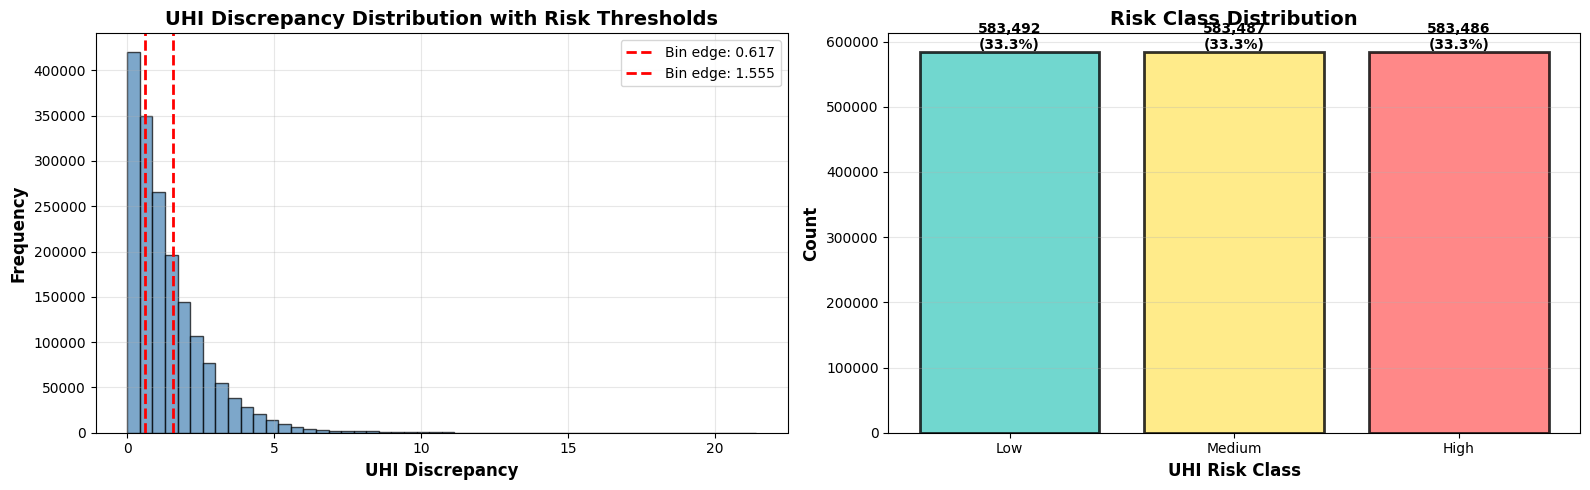

In [83]:
# Visualize binning
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution with bin edges
ax = axes[0]
ax.hist(uhi_with_degurba["UHI_discrepancy"].dropna(), bins=50, alpha=0.7, color="steelblue", edgecolor="black")
for edge in quantiles[1:-1]:
    ax.axvline(x=edge, color="red", linestyle="--", linewidth=2, label=f"Bin edge: {edge:.3f}")
ax.set_xlabel("UHI Discrepancy", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax.set_title("UHI Discrepancy Distribution with Risk Thresholds", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)

# Class distribution bar chart
ax = axes[1]
colors = ["#4ECDC4", "#FFE66D", "#FF6B6B"]
bars = ax.bar(risk_counts.index, risk_counts.values, color=colors, alpha=0.8, edgecolor="black", linewidth=2)
ax.set_xlabel("UHI Risk Class", fontsize=12, fontweight="bold")
ax.set_ylabel("Count", fontsize=12, fontweight="bold")
ax.set_title("Risk Class Distribution", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

for bar, count in zip(bars, risk_counts.values):
    height = bar.get_height()
    pct = count / len(uhi_with_degurba) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{count:,}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

## 7. Prepare Features for Classification

### Feature Selection Rationale

We select **8 environmental and geographic features** that influence UHI formation:

**Meteorological Features (ERA5):**

- `ERA5_t2m`: 2-meter temperature - direct measure of ambient heat
- `ERA5_u10`, `ERA5_v10`: Wind components at 10m - affects heat dispersion
- `ERA5_tp`: Total precipitation - influences evaporative cooling
- `ERA5_UHI`: ERA5's own estimate of urban heat island intensity

**Geographic Features:**

- `HGHT`: Elevation above sea level

**Land Cover Features:**

- `NDVI`: Vegetation index (proxy for urbanization)

**Urbanization Feature:**

- `DEGURBA`: Official EU urban density classification

### Features NOT Used (Why?)

- `x`, `y` coordinates: Could cause overfitting to specific locations (removed for generalization)
- `date`, `SOUID`: Temporal/station identifiers, not predictive
- `ECA_TX`, `ECA_UHI`: Ground truth measurements

### Data Cleaning

1. **Remove NaN values**: ML models require complete data
2. **Sampling**: Use 100k records for faster training (representative subset)
3. **No feature scaling yet**: Will apply selectively based on model requirements


In [84]:
# Select feature columns
feature_cols = ["HGHT", "ERA5_t2m", "ERA5_u10", "ERA5_v10", "ERA5_tp", "NDVI", "ERA5_UHI", "DEGURBA"]

# Remove rows with missing values in features or target
data_clean = uhi_with_degurba[feature_cols + ["UHI_risk"]].dropna().copy()

print(f"Data after removing missing values: {len(data_clean):,} rows")
print(f"\nFeatures: {feature_cols}")

# Separate features and target
X = data_clean[feature_cols].copy()
y = data_clean["UHI_risk"].copy()

# Sample for faster training if dataset is very large
sample_size = min(100_000, len(X))
if len(X) > sample_size:
    print(f"\nSampling {sample_size:,} records for training (out of {len(X):,})...")
    sample_idx = np.random.RandomState(42).choice(len(X), sample_size, replace=False)
    X = X.iloc[sample_idx].reset_index(drop=True)
    y = y.iloc[sample_idx].reset_index(drop=True)

print(f"\n✓ Final feature matrix: {X.shape}")
print(f"✓ Final target vector: {y.shape}")
print("\nTarget distribution:")
print(y.value_counts().sort_index())

Data after removing missing values: 1,750,465 rows

Features: ['HGHT', 'ERA5_t2m', 'ERA5_u10', 'ERA5_v10', 'ERA5_tp', 'NDVI', 'ERA5_UHI', 'DEGURBA']

Sampling 100,000 records for training (out of 1,750,465)...

✓ Final feature matrix: (100000, 8)
✓ Final target vector: (100000,)

Target distribution:
UHI_risk
Low       33535
Medium    33243
High      33222
Name: count, dtype: int64

✓ Final feature matrix: (100000, 8)
✓ Final target vector: (100000,)

Target distribution:
UHI_risk
Low       33535
Medium    33243
High      33222
Name: count, dtype: int64


### Train/Test Split Strategy

**80/20 split** with **stratification** to ensure:

- Training set: 80,000 samples for model learning
- Test set: 20,000 samples for unbiased evaluation
- **Stratification**: Each split maintains the same class distribution (33% each class)

### Feature Scaling (StandardScaler)

**Transforms features to zero mean and unit variance:**

```
scaled_value = (original_value - mean) / std_deviation
```

**Models that NEED scaling:**

- Logistic Regression, SVM, KNN, Neural Networks
- Reason: These use distance metrics or gradient descent (scale-sensitive)

**Models that DON'T need scaling:**

- Decision Trees, Random Forest, Gradient Boosting
- Reason: These use decision rules (split points), not distances

### Label Encoding

**Converts categorical labels to numbers:**

- "Low" → 0
- "Medium" → 1
- "High" → 2

**Why needed**: Some models (Neural Networks, SVM) require numeric inputs. We'll convert predictions back to original labels for interpretability.


In [ ]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest set class distribution:")
print(y_test.value_counts().sort_index())

# Scale features for models that benefit from it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Feature scaling complete")

# Encode categorical labels to numeric for models that require it
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(
    f"✓ Label encoding complete: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}"
)

Training set: 80,000 samples
Test set: 20,000 samples

Training set class distribution:
UHI_risk
Low       26828
Medium    26594
High      26578
Name: count, dtype: int64

Test set class distribution:
UHI_risk
Low       6707
Medium    6649
High      6644
Name: count, dtype: int64

✓ Feature scaling complete
✓ Label encoding complete: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}
✓ Label encoding complete: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


## 8. Train Classification Models

### Model Selection Strategy
We train **8 different ML algorithms** representing diverse learning approaches:

**1. Logistic Regression** (Linear baseline)
- Simple, interpretable, fast
- Good for understanding feature coefficients
- Expects linear decision boundaries

**2. Decision Tree** (Single tree)
- Interpretable rules: "If NDVI < 0.3 AND DEGURBA = 1, then HIGH risk"
- Prone to overfitting without depth limits

**3. Random Forest** (Ensemble of trees)
- Combines 100 decision trees with bootstrap sampling
- Reduces overfitting through averaging
- Provides feature importance scores

**4. Gradient Boosting** (Sequential ensemble)
- Builds trees sequentially, each correcting previous errors
- Often best performance but slower to train
- More prone to overfitting than Random Forest

**5. XGBoost** (Optimized gradient boosting)
- Extreme Gradient Boosting with regularization and parallel processing
- Often outperforms standard Gradient Boosting
- Handles missing values and provides feature importance
- Industry-standard for tabular data competitions

**6. K-Nearest Neighbors (KNN)** (Instance-based)
- Classifies based on 10 nearest training examples
- Simple but computationally expensive at prediction time
- Sensitive to feature scaling (requires normalization)

**7. Support Vector Machine (SVM)** (Maximum margin)
- Finds optimal decision boundary between classes
- RBF kernel for non-linear patterns
- Requires scaled features and encoded labels

**8. Neural Network (MLP)** (Deep learning)
- Two hidden layers (100, 50 neurons)
- Can learn complex non-linear patterns
- Requires scaled features, encoded labels, and more training data

### Evaluation Metrics
For each model we compute:
- **Accuracy**: Overall correct predictions (target: >60%)
- **Precision**: Of predicted HIGH risk, how many are actually HIGH?
- **Recall**: Of actual HIGH risk cases, how many did we catch?
- **F1 Score**: Harmonic mean of precision and recall (balanced metric)

In [ ]:
# Define evaluation function
def evaluate_classifier(name, model, X_train, X_test, y_train, y_test, use_scaled=False, use_encoded=False):
    """Train and evaluate a classification model"""

    # Select appropriate data
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    # Select appropriate labels
    y_tr = y_train_encoded if use_encoded else y_train
    y_te = y_test_encoded if use_encoded else y_test

    print(f"\nTraining {name}...")
    model.fit(X_tr, y_tr)

    # Make predictions
    y_pred_test = model.predict(X_te)

    # Convert predictions back to original labels if encoded
    if use_encoded:
        y_pred_test = label_encoder.inverse_transform(y_pred_test)
        y_te = y_test  # Use original labels for metrics

    # Calculate metrics
    test_acc = accuracy_score(y_te, y_pred_test)
    test_precision = precision_score(y_te, y_pred_test, average="weighted", zero_division=0)
    test_recall = recall_score(y_te, y_pred_test, average="weighted", zero_division=0)
    test_f1 = f1_score(y_te, y_pred_test, average="weighted", zero_division=0)
    cm = confusion_matrix(y_te, y_pred_test, labels=class_labels)

    print(
        f"  ✓ Accuracy: {test_acc:.4f} | F1: {test_f1:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f}"
    )

    return {
        "model": model,
        "accuracy": test_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1,
        "confusion_matrix": cm,
        "predictions": y_pred_test,
    }


# Dictionary to store results
results = {}

print("=" * 80)
print("TRAINING CLASSIFICATION MODELS")
print("=" * 80)

TRAINING CLASSIFICATION MODELS


In [ ]:
# Train Logistic Regression
results["Logistic Regression"] = evaluate_classifier(
    "Logistic Regression",
    LogisticRegression(max_iter=1000, random_state=42, multi_class="multinomial"),
    X_train,
    X_test,
    y_train,
    y_test,
    use_scaled=True,
)

# Train Decision Tree
results["Decision Tree"] = evaluate_classifier(
    "Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=15), X_train, X_test, y_train, y_test
)

# Train Random Forest
results["Random Forest"] = evaluate_classifier(
    "Random Forest",
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15),
    X_train,
    X_test,
    y_train,
    y_test,
)

# Train Gradient Boosting
results["Gradient Boosting"] = evaluate_classifier(
    "Gradient Boosting",
    GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    X_train,
    X_test,
    y_train,
    y_test,
)

# Train XGBoost
results["XGBoost"] = evaluate_classifier(
    "XGBoost",
    XGBClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1, n_jobs=-1, eval_metric="mlogloss"),
    X_train,
    X_test,
    y_train,
    y_test,
    use_encoded=True,
)

# Train KNN
results["KNN"] = evaluate_classifier(
    "KNN", KNeighborsClassifier(n_neighbors=10, n_jobs=-1), X_train, X_test, y_train, y_test, use_scaled=True
)


# Train Neural Network (requires numeric labels)
results["Neural Network"] = evaluate_classifier(
    "Neural Network (MLP)",
    MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True),
    X_train,
    X_test,
    y_train,
    y_test,
    use_scaled=True,
    use_encoded=True,
)

print("\n" + "=" * 80)
print("✓ ALL MODELS TRAINED")
print("=" * 80)


Training Logistic Regression...


  ✓ Accuracy: 0.4546 | F1: 0.4366 | Precision: 0.4441 | Recall: 0.4546

Training Decision Tree...
  ✓ Accuracy: 0.5481 | F1: 0.5472 | Precision: 0.5474 | Recall: 0.5481

Training Random Forest...
  ✓ Accuracy: 0.5481 | F1: 0.5472 | Precision: 0.5474 | Recall: 0.5481

Training Random Forest...
  ✓ Accuracy: 0.5908 | F1: 0.5849 | Precision: 0.5843 | Recall: 0.5908

Training Gradient Boosting...
  ✓ Accuracy: 0.5908 | F1: 0.5849 | Precision: 0.5843 | Recall: 0.5908

Training Gradient Boosting...
  ✓ Accuracy: 0.5364 | F1: 0.5285 | Precision: 0.5260 | Recall: 0.5364

Training XGBoost...
  ✓ Accuracy: 0.5364 | F1: 0.5285 | Precision: 0.5260 | Recall: 0.5364

Training XGBoost...
  ✓ Accuracy: 0.5304 | F1: 0.5212 | Precision: 0.5188 | Recall: 0.5304

Training KNN...
  ✓ Accuracy: 0.5304 | F1: 0.5212 | Precision: 0.5188 | Recall: 0.5304

Training KNN...
  ✓ Accuracy: 0.5049 | F1: 0.4976 | Precision: 0.4969 | Recall: 0.5049

Training Neural Network (MLP)...
  ✓ Accuracy: 0.5049 | F1: 0.4976 | P

## 9. Model Comparison

### Performance Metrics Explained

**Accuracy**: Percentage of correct predictions across all classes
- Good for balanced datasets (which we have thanks to quantile binning)
- **Limitation**: Doesn't tell us which classes are predicted well

**Precision (weighted)**: For each class, how many predictions were correct?
- HIGH precision for "High risk" = few false alarms
- Important when intervention costs are high

**Recall (weighted)**: For each class, what percentage did we catch?
- HIGH recall for "High risk" = we don't miss dangerous areas
- Important for public safety applications

**F1 Score (weighted)**: Harmonic mean balancing precision and recall
- **Best overall metric** for multi-class problems
- Ranges from 0 (worst) to 1 (perfect)

### Interpreting Results
**Good performance** (for this complex task):
- Accuracy > 0.55 (better than 0.33 random baseline)
- F1 Score > 0.50
- Balanced precision and recall

**Expected winner**: Random Forest or Gradient Boosting
- These ensemble methods typically excel at tabular data
- Can capture non-linear interactions (e.g., DEGURBA × NDVI)

### Model Selection Criteria
1. **Highest accuracy/F1** on test set
2. **Low overfitting** (train vs test gap < 0.10)
3. **Interpretability** (if similar performance, prefer simpler models)

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame(
    {
        "Model": list(results.keys()),
        "Accuracy": [results[m]["accuracy"] for m in results],
        "Precision": [results[m]["precision"] for m in results],
        "Recall": [results[m]["recall"] for m in results],
        "F1 Score": [results[m]["f1"] for m in results],
    }
).sort_values("Accuracy", ascending=False)

print("=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Best model
best_model_name = comparison_df.iloc[0]["Model"]
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy:  {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"   F1 Score:  {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"   Precision: {comparison_df.iloc[0]['Precision']:.4f}")
print(f"   Recall:    {comparison_df.iloc[0]['Recall']:.4f}")

MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision  Recall  F1 Score
      Random Forest   0.59085   0.584304 0.59085  0.584865
      Decision Tree   0.54805   0.547441 0.54805  0.547225
  Gradient Boosting   0.53645   0.526005 0.53645  0.528545
            XGBoost   0.53045   0.518762 0.53045  0.521193
     Neural Network   0.50860   0.493862 0.50860  0.493607
                KNN   0.50485   0.496945 0.50485  0.497632
Logistic Regression   0.45460   0.444062 0.45460  0.436576

🏆 BEST MODEL: Random Forest
   Accuracy:  0.5908
   F1 Score:  0.5849
   Precision: 0.5843
   Recall:    0.5908


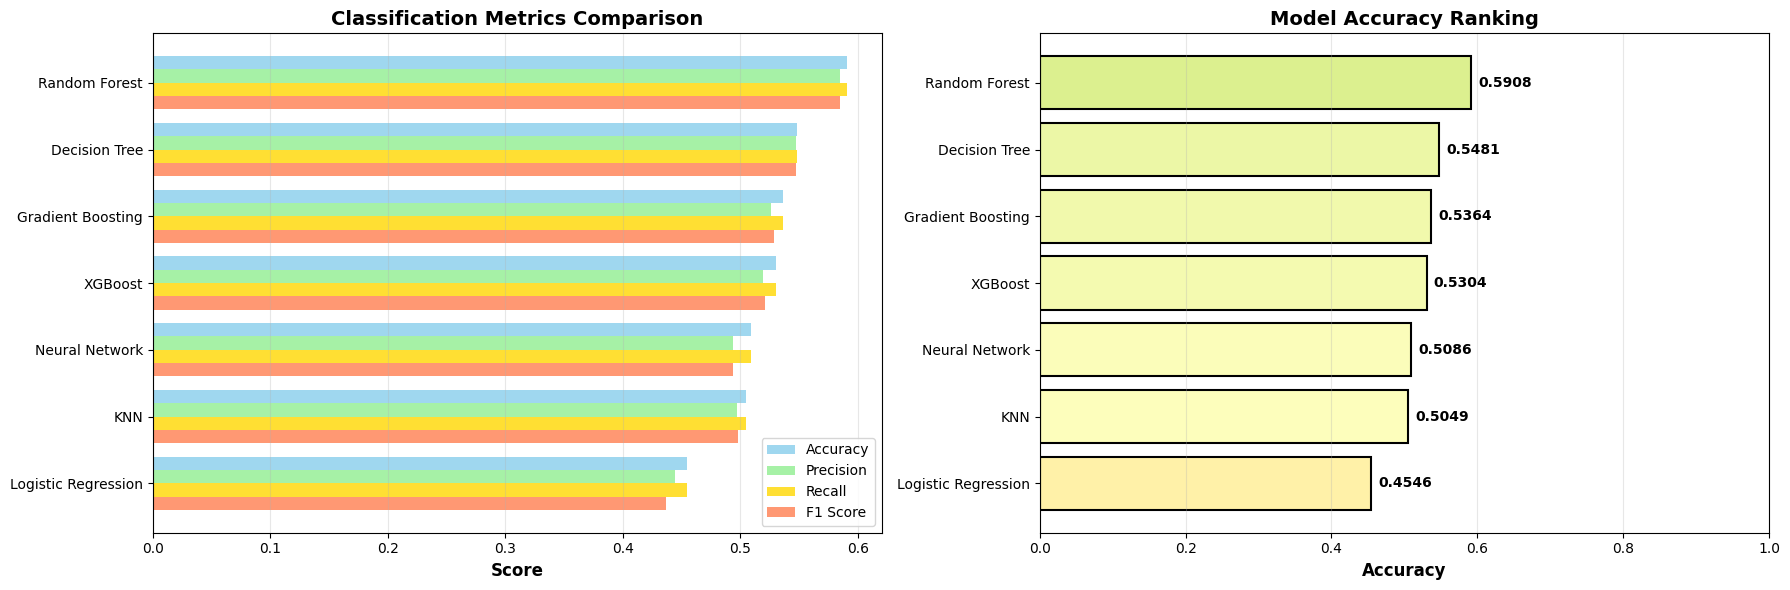

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart: All metrics
ax = axes[0]
x_pos = np.arange(len(comparison_df))
width = 0.2
ax.barh(x_pos - 1.5 * width, comparison_df["Accuracy"], width, label="Accuracy", alpha=0.8, color="skyblue")
ax.barh(x_pos - 0.5 * width, comparison_df["Precision"], width, label="Precision", alpha=0.8, color="lightgreen")
ax.barh(x_pos + 0.5 * width, comparison_df["Recall"], width, label="Recall", alpha=0.8, color="gold")
ax.barh(x_pos + 1.5 * width, comparison_df["F1 Score"], width, label="F1 Score", alpha=0.8, color="coral")
ax.set_yticks(x_pos)
ax.set_yticklabels(comparison_df["Model"])
ax.set_xlabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Classification Metrics Comparison", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()

# Accuracy ranking
ax = axes[1]
colors_grad = plt.cm.RdYlGn(comparison_df["Accuracy"])
bars = ax.barh(comparison_df["Model"], comparison_df["Accuracy"], color=colors_grad, edgecolor="black", linewidth=1.5)
ax.set_xlabel("Accuracy", fontsize=12, fontweight="bold")
ax.set_title("Model Accuracy Ranking", fontsize=14, fontweight="bold")
ax.set_xlim(0, 1)
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()

for bar, acc in zip(bars, comparison_df["Accuracy"]):
    width = bar.get_width()
    ax.text(
        width + 0.01,
        bar.get_y() + bar.get_height() / 2.0,
        f"{acc:.4f}",
        ha="left",
        va="center",
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

## 10. Confusion Matrices

### What to Look For

1. **High risk detection**: Bottom-right cell should be large (catching dangerous areas)
2. **False positives**: Bottom row off-diagonal (predicting High when it's actually Low/Med)
3. **False negatives**: Right column off-diagonal (missing High risk areas)

**Public safety priority**: Minimize false negatives (bottom row off-diagonal) even if it means more false positives.


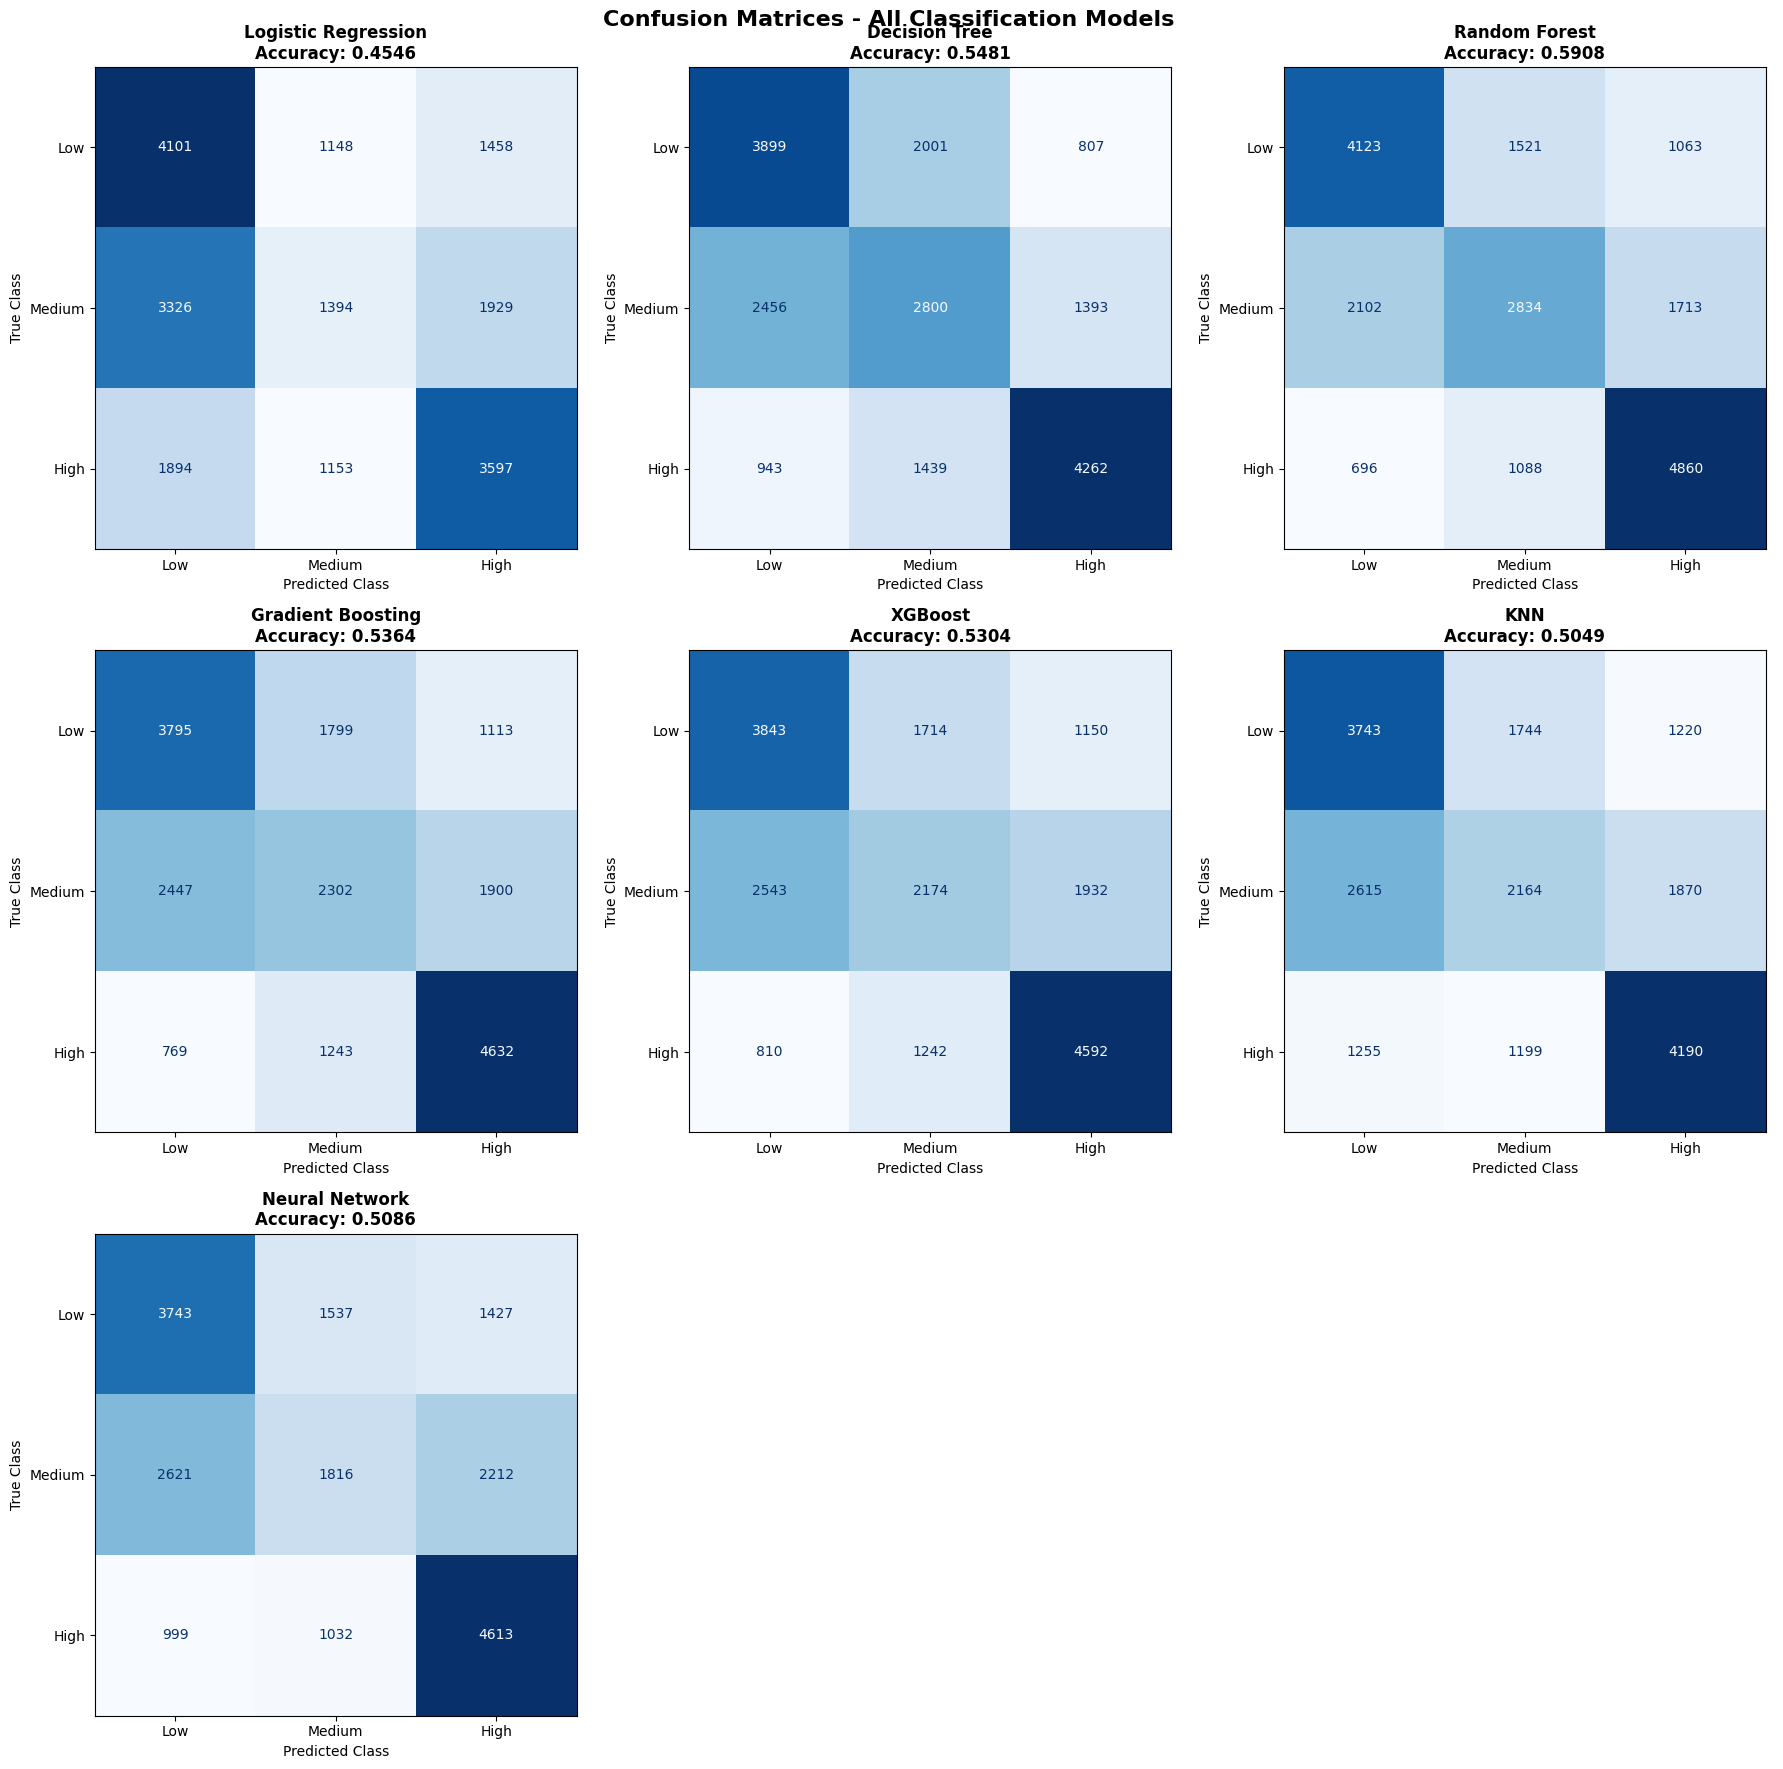

In [ ]:
# Plot confusion matrices for all models
n_models = len(results)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (model_name, res) in enumerate(results.items()):
    ax = axes[idx]
    cm = res["confusion_matrix"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)

    ax.set_title(f"{model_name}\nAccuracy: {res['accuracy']:.4f}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted Class", fontsize=10)
    ax.set_ylabel("True Class", fontsize=10)

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis("off")

plt.suptitle("Confusion Matrices - All Classification Models", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## 11. Best Model Analysis

### Detailed Performance Breakdown

The classification report provides **per-class metrics**:

**For each risk level (Low, Medium, High):**
- **Precision**: Of all predictions for this class, what % were correct?
  - High precision for "High" = when we warn about high risk, we're usually right
- **Recall**: Of all actual cases in this class, what % did we detect?
  - High recall for "High" = we catch most of the dangerous areas
- **F1-score**: Balance between precision and recall for this class
  - Most important metric for actionable decisions

**Support**: Number of actual samples in each class (should be ~6,666 each due to balanced dataset)

### Feature Importance Analysis

**For tree-based models (Random Forest, Gradient Boosting, Decision Tree):**
Feature importance scores reveal which variables drive predictions:
- **High importance** (>0.15): Critical decision factors
- **Medium importance** (0.05-0.15): Supporting information
- **Low importance** (<0.05): Minimal predictive value

**Expected top features:**
1. **DEGURBA**: Urban density directly correlates with UHI effects
2. **NDVI**: Vegetation proxy for urbanization
3. **ERA5_t2m**: Base temperature affects heat island intensity

**For linear models (Logistic Regression):**
Coefficients show direction and strength of relationships:
- **Positive coefficient**: Higher value → Higher risk class
- **Negative coefficient**: Higher value → Lower risk class
- **Large absolute value**: Strong influence on prediction

DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

         Low       0.64      0.73      0.68      6644
      Medium       0.60      0.61      0.61      6707
        High       0.52      0.43      0.47      6649

    accuracy                           0.59     20000
   macro avg       0.58      0.59      0.58     20000
weighted avg       0.58      0.59      0.58     20000


FEATURE IMPORTANCE
 Feature  Importance
    HGHT    0.254526
ERA5_UHI    0.187988
ERA5_t2m    0.116384
ERA5_u10    0.110798
ERA5_v10    0.108110
 ERA5_tp    0.098184
    NDVI    0.091966
 DEGURBA    0.032045

FEATURE IMPORTANCE
 Feature  Importance
    HGHT    0.254526
ERA5_UHI    0.187988
ERA5_t2m    0.116384
ERA5_u10    0.110798
ERA5_v10    0.108110
 ERA5_tp    0.098184
    NDVI    0.091966
 DEGURBA    0.032045


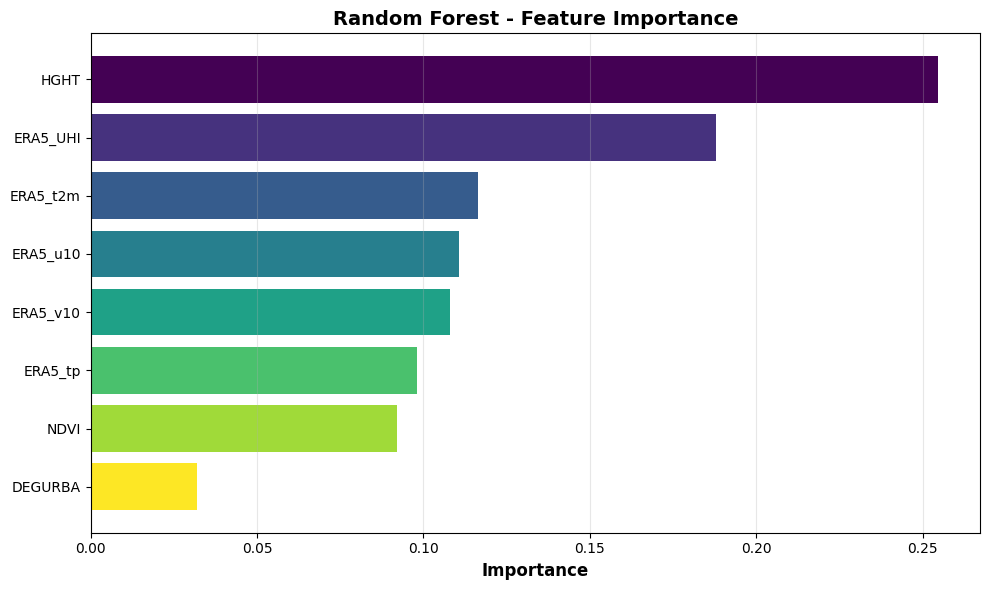

In [ ]:
# Detailed classification report for best model
print("=" * 80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("=" * 80)
best_predictions = results[best_model_name]["predictions"]
print(classification_report(y_test, best_predictions, target_names=class_labels))

# Feature importance (if available)
best_model = results[best_model_name]["model"]

if hasattr(best_model, "feature_importances_"):
    print("\n" + "=" * 80)
    print("FEATURE IMPORTANCE")
    print("=" * 80)

    importances = best_model.feature_importances_
    importance_df = pd.DataFrame({"Feature": feature_cols, "Importance": importances}).sort_values(
        "Importance", ascending=False
    )

    print(importance_df.to_string(index=False))

    # Visualize feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
    ax.barh(range(len(importance_df)), importance_df["Importance"], color=colors)
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels(importance_df["Feature"])
    ax.set_xlabel("Importance", fontsize=12, fontweight="bold")
    ax.set_title(f"{best_model_name} - Feature Importance", fontsize=14, fontweight="bold")
    ax.grid(axis="x", alpha=0.3)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, "coef_"):
    print("\n" + "=" * 80)
    print("FEATURE COEFFICIENTS (ABSOLUTE VALUES)")
    print("=" * 80)

    # For multi-class, take mean absolute coefficient across classes
    if len(best_model.coef_.shape) > 1:
        importances = np.abs(best_model.coef_).mean(axis=0)
    else:
        importances = np.abs(best_model.coef_)

    importance_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": importances}).sort_values(
        "Coefficient", ascending=False
    )

    print(importance_df.to_string(index=False))